# Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow.keras.layers as layers
import time

from IPython import display
%matplotlib inline

# Augmentate Dataset

In [3]:
PATH = 'pokemon'
NEW_PATH = 'pokemon-2'
WIDTH = 128
HEIGHT = 128
DEGREES = [-10, 10]

### Convert images to RGB and make resolution lower

In [75]:
for filename in os.listdir(PATH):
    # Open image
    img = PIL.Image.open('{}/{}'.format(PATH, filename))
    # Convert image from RGBA to RGB
    new_img = PIL.Image.new('RGB', img.size, (255, 255, 255))
    # Get converted img, 3 - alpha chanel
    new_img.paste(img, mask=img.split()[3])
    # Resize image
    new_img = new_img.resize((WIDTH, HEIGHT))
    # Save image
    new_img.save(NEW_PATH + '/' + filename[:-3] + 'jpg', 'JPEG', quality=100)

### Flip images

In [76]:
for filename in os.listdir(NEW_PATH):
    img = PIL.Image.open('{}/{}'.format(NEW_PATH, filename))
    new_img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    new_img.save(NEW_PATH + '/' + filename[:-4] + '_flipped.jpg', 'JPEG', quality=100)

### Rotate images

In [78]:
for filename in os.listdir(NEW_PATH):
    for degree in DEGREES:
        img = PIL.Image.open('{}/{}'.format(NEW_PATH, filename))
        new_img = img.convert('RGBA')
        new_img = new_img.rotate(degree)
        background = PIL.Image.new('RGB', new_img.size, (255, 255, 255))
        background.paste(new_img, mask=new_img.split()[3])
        background.save(NEW_PATH + '/' + filename[:-4] + '_rotated_{}.jpg'.format(degree), 
                        'JPEG', quality=100)

### Load images 

In [4]:
train_images = []
for filename in os.listdir(NEW_PATH):
    img = PIL.Image.open('{}/{}'.format(NEW_PATH, filename)).convert('RGB')
    train_images.append(np.array(img))
train_images = np.array(train_images)

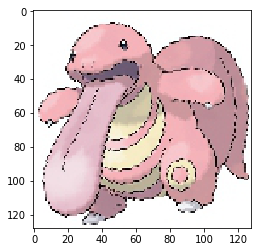

In [5]:
plt.imshow(train_images[55])

In [6]:
train_images.shape

(4914, 128, 128, 3)

In [7]:
train_images = train_images.reshape(train_images.shape[0], WIDTH, HEIGHT, 3).astype(np.float32)
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5 

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
train_dataset

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>

# Create the model

### The generator

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                    padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2),
                                    padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2),
                                    padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)
    
    return model

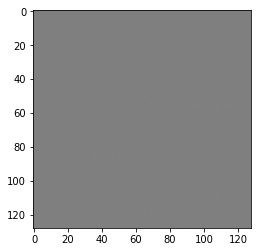

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(tf.dtypes.cast((generated_image[0] * 127.5 + 127.5), tf.int32))

### The Discriminator

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
      
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
       
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
     
    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00020836]], shape=(1, 1), dtype=float32)


#  Define the loss and optimizers

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss 

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [19]:
checkpoint_dir = '.training_ckeckpoints-2'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the training loop

In [20]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 64

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

### Generate and save images

In [23]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(16, 16))
    
    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(tf.dtypes.cast((predictions[i] * 127.5 + 127.5), tf.int32))
        
    plt.savefig('img-2/image_at_epoch_{:04d}.jpg'.format(epoch))
    plt.show()

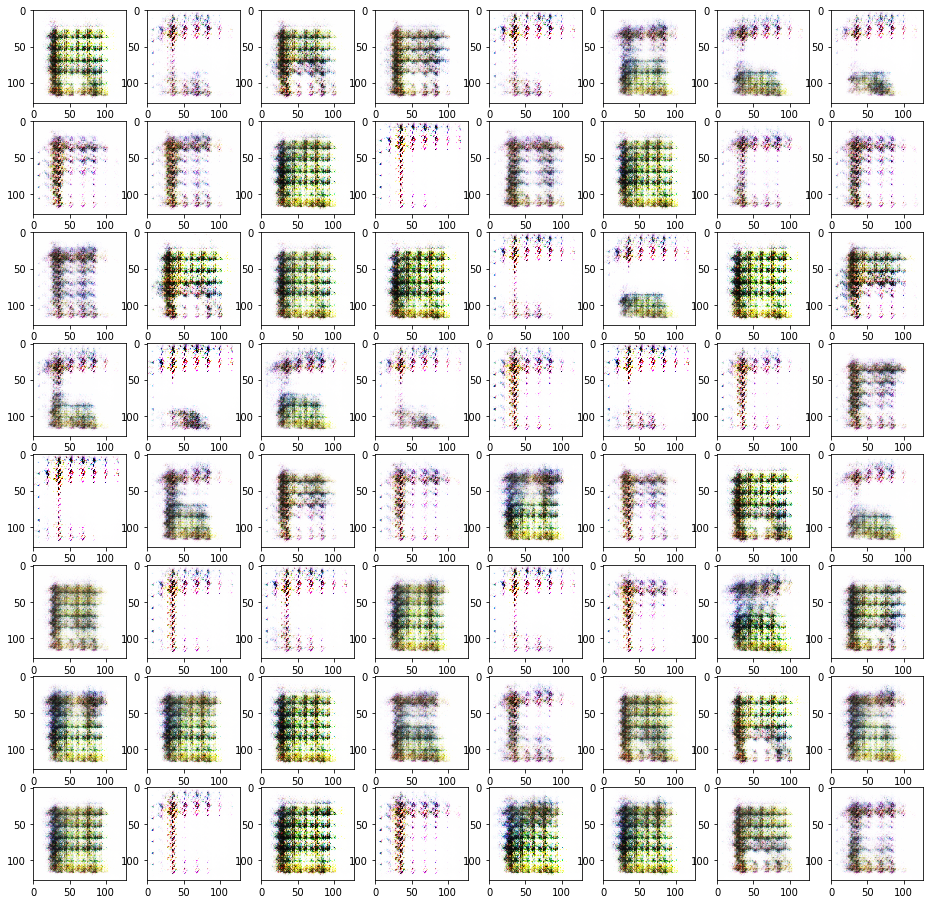

Time for epoch 62 is 58.92571258544922 sec


In [ ]:
%%time
train(train_dataset, EPOCHS)

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

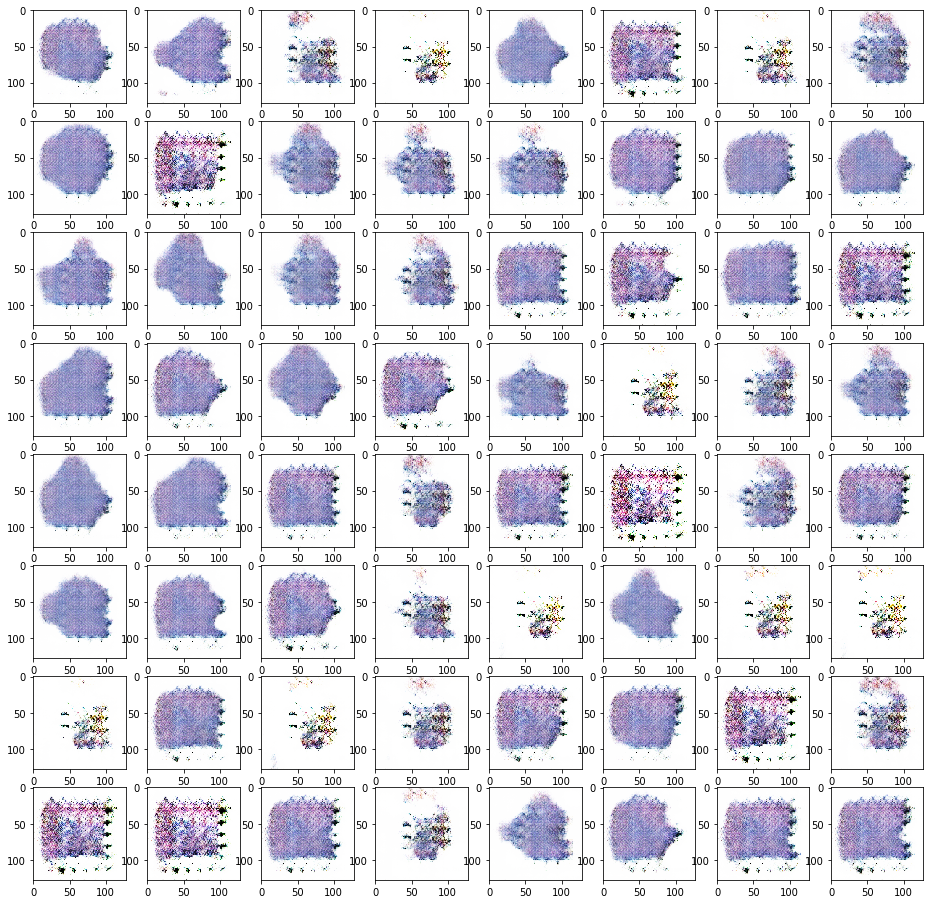

Time for epoch 201 is 81.89368200302124 sec


KeyboardInterrupt: 

In [25]:
%%time
train(train_dataset, EPOCHS)